# Lesson 3: Show the data as it is acquired

In this lesson, we'll show how to use the tools provided with Bluesky to show the data as it is acquired using both a table representation and a graphical view, as well.  These capabilities are provided by using *callbacks*.  In lessons 1 and 2, we wrote our own simple callback to view the documents that come from the RunEngine during execution of a plan.  Quickly, the data became too complex for simple viewing.

The *LiveTable* and *LivePlot* callbacks provide a table and graphical view of the data from the plan.  We'll get to those first.  Later, we'll show the *BestEffortCallback*, which combines both those callbacks plus a little more.  For routine work, we'll want to use *BestEffortCallback* all the time.  We'll show how to make that happen so we *set it and forget about it*.

----------------------

Starting with the configuration from lessons 1 and 2, we first group the *imports* together as is common Python practice:

In [1]:
from ophyd import EpicsMotor
from ophyd.scaler import ScalerCH
from bluesky import RunEngine
import bluesky.plans as bp
from APS_BlueSky_tools.devices import use_EPICS_scaler_channels

Next, make a RunEngine (for scanning) and connect our motor and scaler

In [2]:
RE = RunEngine({})
m1 = EpicsMotor("prj:m1", name="m1")
scaler = ScalerCH("prj:scaler1", name="scaler")

Reconfigure the scaler for channel names and show the result.

In [3]:
scaler.channels.chan01.chname.put("clock")
scaler.channels.chan02.chname.put("I0")
scaler.channels.chan03.chname.put("scint")

scaler.match_names()
use_EPICS_scaler_channels(scaler)
scaler.read()

OrderedDict([('clock', {'value': 11000000.0, 'timestamp': 1533084322.433813}),
             ('I0', {'value': 2.0, 'timestamp': 1533084322.433813}),
             ('scint', {'value': 5.0, 'timestamp': 1533084322.433813}),
             ('scaler_time', {'value': 1.1, 'timestamp': 1533084322.433813})])

## Showing the data

In [4]:
from bluesky.callbacks import LiveTable

In [5]:
RE(bp.scan([scaler], m1, 1, 5, 5), LiveTable([scaler]))

+-----------+------------+------------+------------+-------------+------------+
|   seq_num |       time |         I0 |      clock | scaler_time |      scint |
+-----------+------------+------------+------------+-------------+------------+
|         1 | 20:18:33.8 |          4 |   11000000 |       1.100 |          6 |
|         2 | 20:18:36.2 |          4 |   11000000 |       1.100 |          3 |
|         3 | 20:18:38.6 |          5 |   11000000 |       1.100 |          5 |
|         4 | 20:18:41.0 |          5 |   11000000 |       1.100 |          5 |
|         5 | 20:18:43.4 |          6 |   11000000 |       1.100 |          5 |
+-----------+------------+------------+------------+-------------+------------+
generator scan ['e7650a56'] (scan num: 1)


('e7650a56-b0c8-4370-9ec1-555550d1c00c',)

In [6]:
RE.subscribe(LiveTable([scaler]))

1

In [7]:
RE(bp.scan([scaler], m1, 1, 5, 5))

+-----------+------------+------------+------------+-------------+------------+
|   seq_num |       time |         I0 |      clock | scaler_time |      scint |
+-----------+------------+------------+------------+-------------+------------+
|         1 | 20:18:58.6 |          4 |   11000000 |       1.100 |          4 |
|         2 | 20:19:01.1 |          5 |   11000000 |       1.100 |          5 |
|         3 | 20:19:03.6 |          5 |   11000000 |       1.100 |          5 |
|         4 | 20:19:06.1 |          6 |   11000000 |       1.100 |          7 |
|         5 | 20:19:08.6 |          6 |   11000000 |       1.100 |          6 |
+-----------+------------+------------+------------+-------------+------------+
generator scan ['8b14088b'] (scan num: 2)


('8b14088b-05a4-414d-9c36-e6eae1bc6496',)

---------
see http://nsls-ii.github.io/bluesky/callbacks.html#aside-making-plots-update-live

In [8]:
%matplotlib notebook
from bluesky.utils import install_nb_kicker
install_nb_kicker()

In [9]:
from bluesky.callbacks import LivePlot

<IPython.core.display.Javascript object>


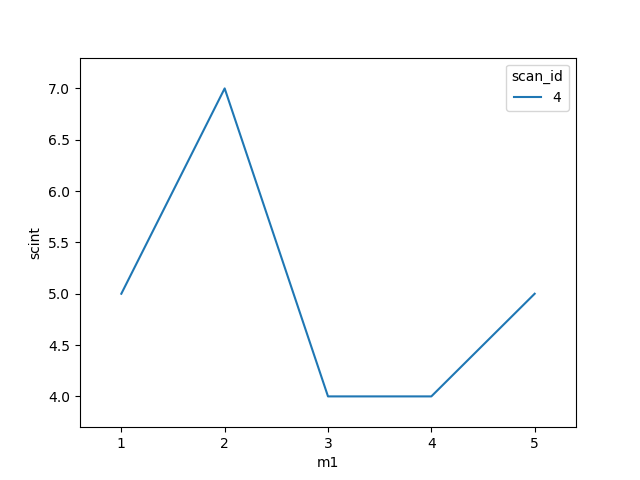

+-----------+------------+------------+------------+-------------+------------+
|   seq_num |       time |         I0 |      clock | scaler_time |      scint |
+-----------+------------+------------+------------+-------------+------------+
|         1 | 20:21:10.7 |          6 |   11000000 |       1.100 |          5 |
|         2 | 20:21:13.1 |          4 |   11000000 |       1.100 |          7 |
|         3 | 20:21:15.5 |          4 |   11000000 |       1.100 |          4 |
|         4 | 20:21:18.0 |          4 |   11000000 |       1.100 |          4 |
|         5 | 20:21:20.6 |          7 |   11000000 |       1.100 |          5 |
+-----------+------------+------------+------------+-------------+------------+
generator scan ['0aebe5ca'] (scan num: 4)


('0aebe5ca-1f62-43bc-984e-3a505f54b864',)

In [14]:
RE(bp.scan([scaler], m1, 1, 5, 5), LivePlot("scint", "m1"))

<IPython.core.display.Javascript object>


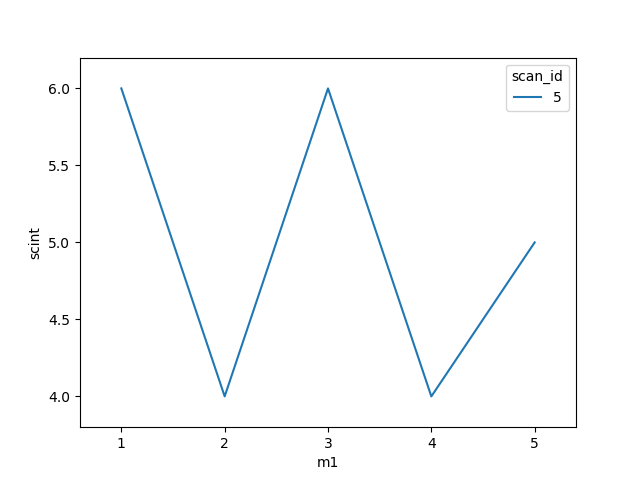

5

In [16]:
RE.subscribe(LivePlot("scint", "m1"))

In [17]:
RE(bp.scan([scaler], m1, 1, 5, 5))

+-----------+------------+------------+------------+-------------+------------+
|   seq_num |       time |         I0 |      clock | scaler_time |      scint |
+-----------+------------+------------+------------+-------------+------------+
|         1 | 20:25:24.2 |          4 |   11000000 |       1.100 |          6 |
|         2 | 20:25:26.8 |          4 |   11000000 |       1.100 |          4 |
|         3 | 20:25:29.3 |          3 |   11000000 |       1.100 |          6 |
|         4 | 20:25:31.8 |          5 |   10000000 |       1.000 |          4 |
|         5 | 20:25:34.2 |          4 |   11000000 |       1.100 |          5 |
+-----------+------------+------------+------------+-------------+------------+
generator scan ['0ba179ed'] (scan num: 5)


('0ba179ed-a935-4a52-ac10-5ba433303dcc',)

In [24]:
RE.dispatcher.unsubscribe_all()

------------------
see http://nsls-ii.github.io/bluesky/callbacks.html#best-effort-callback

In [26]:
from bluesky.callbacks.best_effort import BestEffortCallback

Transient Scan ID: 6     Time: 2018/07/31 20:28:44
Persistent Unique Scan ID: '05ff6bab-e27d-4946-be85-28c27693e1ba'
New stream: 'primary'
+-----------+------------+------------+------------+------------+------------+
|   seq_num |       time |         m1 |      clock |         I0 |      scint |
+-----------+------------+------------+------------+------------+------------+


<IPython.core.display.Javascript object>


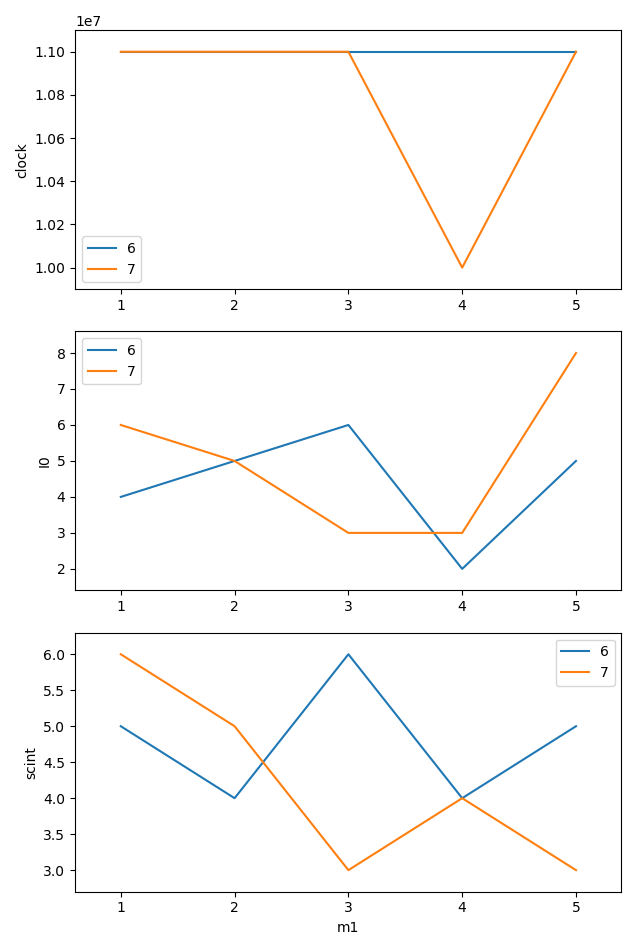

|         1 | 20:28:50.6 |    1.00000 |   11000000 |          4 |          5 |
|         2 | 20:28:53.2 |    2.00000 |   11000000 |          5 |          4 |
|         3 | 20:28:55.8 |    3.00000 |   11000000 |          6 |          6 |
|         4 | 20:28:58.6 |    4.00000 |   11000000 |          2 |          4 |
|         5 | 20:29:01.2 |    5.00000 |   11000000 |          5 |          5 |
+-----------+------------+------------+------------+------------+------------+
generator scan ['05ff6bab'] (scan num: 6)





('05ff6bab-e27d-4946-be85-28c27693e1ba',)

In [27]:
RE(bp.scan([scaler], m1, 1, 5, 5), BestEffortCallback())

In [28]:
RE.subscribe(BestEffortCallback())

7

In [29]:
RE(bp.scan([scaler], m1, 1, 5, 5))

Transient Scan ID: 7     Time: 2018/07/31 20:29:17
Persistent Unique Scan ID: '5b348825-ccdf-4a2a-a98d-181c5b897b96'
New stream: 'primary'
+-----------+------------+------------+------------+------------+------------+
|   seq_num |       time |         m1 |      clock |         I0 |      scint |
+-----------+------------+------------+------------+------------+------------+
|         1 | 20:29:23.2 |    1.00000 |   11000000 |          6 |          6 |
|         2 | 20:29:25.9 |    2.00000 |   11000000 |          5 |          5 |
|         3 | 20:29:28.4 |    3.00000 |   11000000 |          3 |          3 |
|         4 | 20:29:30.8 |    4.00000 |   10000000 |          3 |          4 |
|         5 | 20:29:33.4 |    5.00000 |   11000000 |          8 |          3 |
+-----------+------------+------------+------------+------------+------------+
generator scan ['5b348825'] (scan num: 7)





('5b348825-ccdf-4a2a-a98d-181c5b897b96',)